# Análisis Exploratorio de los datos de Trocafone



### Propuestas


## Configuracion inicial

In [258]:
#Importo librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [309]:
%matplotlib inline
plt.style.use('default')
sns.set(rc={'figure.figsize':(14.7,8.27)})

In [259]:
#Funciones auxiliares
def mostrar_porcentaje_barplot(ax):
    suma = 0
    for p in ax.patches:
        suma += p.get_height()
    for p in ax.patches:
        ax.annotate(str(np.round(100 *(p.get_height() / suma),decimals=2)) + "%", (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
def mostrar_valores_barplot(ax):
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [260]:
#Cargo el DataFrame
df = pd.read_csv('events.csv', low_memory=False)
df.head(10)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Paid,New,Camaragibe,Pernambuco,Brazil,Smartphone,360x640,Android 6,Chrome Mobile 39
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-05-29 13:29:26,visited site,0006a21a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Paid,New,Rio de Janeiro,Rio de Janeiro,Brazil,Smartphone,360x640,Android 5.1.1,Android 5.1
6,2018-05-29 13:29:27,ad campaign hit,0006a21a,/comprar/samsung/galaxy-s8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-05-29 13:29:35,checkout,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-04-09 20:12:31,generic listing,000a54b2,NaN,NaN,NaN,NaN,NaN,NaN,"10310,13333,13347,9902,9944,12774,12801,12744,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-04-09 20:12:31,visited site,000a54b2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Paid,New,Rio de Janeiro,Rio de Janeiro,Brazil,Computer,1920x1080,Windows 10,Chrome 65.0


## Chequeos de integridad y calidad de los datos


In [261]:
#Arreglo las fechas
df['timestamp']=pd.to_datetime(df['timestamp'])
df['timestamp'].head()

0   2018-05-31 23:38:05
1   2018-05-31 23:38:05
2   2018-05-31 23:38:09
3   2018-05-31 23:38:40
4   2018-05-29 13:29:25
Name: timestamp, dtype: datetime64[ns]

In [262]:
df.describe()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
count,1011288,1011288,1011288,82756,563838,564284,563836,563836,563836,221699,...,50957,87378,87378,87378,87378,87378,87378,87378,87378,87378
unique,793805,11,27624,227,3574,202,5,8,63,35310,...,4,7,2,1939,93,46,4,282,121,343
top,2018-05-15 15:56:06,viewed product,71492f2b,/,2830.0,iPhone 6,Bom,16GB,Preto,"2820,6706,6720,2750,6649,7251,6663,12604,7224,...",...,Google,Paid,Returning,Unknown,Sao Paulo,Brazil,Smartphone,360x640,Windows 7,Chrome 66.0
freq,11,528931,2771,28323,4282,50916,243014,190833,132960,594,...,50240,44193,60480,15819,24996,84308,44239,30009,19675,22611
first,2018-01-01 07:32:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2018-06-15 23:59:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011288 entries, 0 to 1011287
Data columns (total 23 columns):
timestamp                   1011288 non-null datetime64[ns]
event                       1011288 non-null object
person                      1011288 non-null object
url                         82756 non-null object
sku                         563838 non-null object
model                       564284 non-null object
condition                   563836 non-null object
storage                     563836 non-null object
color                       563836 non-null object
skus                        221699 non-null object
search_term                 48967 non-null object
staticpage                  3598 non-null object
campaign_source             82796 non-null object
search_engine               50957 non-null object
channel                     87378 non-null object
new_vs_returning            87378 non-null object
city                        87378 non-null object
region            

In [264]:
#Categorizo ciertas columnas para ahorrar espacio en memoria
for columna  in ['event','condition','storage', 'color', 'staticpage', 'campaign_source', 'search_engine', 'channel', 'new_vs_returning', 'region', 'country', 'device_type']:
        df[columna] = df[columna].astype('category')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011288 entries, 0 to 1011287
Data columns (total 23 columns):
timestamp                   1011288 non-null datetime64[ns]
event                       1011288 non-null category
person                      1011288 non-null object
url                         82756 non-null object
sku                         563838 non-null object
model                       564284 non-null object
condition                   563836 non-null category
storage                     563836 non-null category
color                       563836 non-null category
skus                        221699 non-null object
search_term                 48967 non-null object
staticpage                  3598 non-null category
campaign_source             82796 non-null category
search_engine               50957 non-null category
channel                     87378 non-null category
new_vs_returning            87378 non-null category
city                        87378 non-null object


Como podemos ver, todas las filas especifican 'timestamp', 'event' y 'person'

### Analizamos los valores que pueden tomar las columnas categoricas

In [265]:
valores = df['condition'].unique()
for valor in valores:
    print(valor)

nan
Bom
Muito Bom
Excelente
Bom - Sem Touch ID
Novo


In [266]:
valores = df['storage'].unique()
for valor in valores:
    print(valor)

nan
32GB
64GB
256GB
16GB
8GB
128GB
4GB
512MB


In [267]:
valores = df['channel'].unique()
for valor in valores:
    print(valor)

nan
Paid
Organic
Direct
Social
Referral
Email
Unknown


In [268]:
valores = df['staticpage'].unique()
for valor in valores:
    print(valor)

nan
how-to-buy
trust-trocafone
Quiosks
FaqEcommerce
AboutUs
Conditions
TermsAndConditionsEcommerce
CustomerService
galaxy-s8
how-to-sell
TermsAndConditionsReturnEcommerce
club-trocafone
black_friday
PrivacyEcommerce


## Analisis tipos de evento

In [269]:
colUsadasEventos = df.groupby(by = 'event').count()
colUsadasEventos

,timestamp,person,url,sku,model,condition,storage,color,skus,search_term,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
event,,,,,,,,,,,,,,,,,,,,,
ad campaign hit,82827,82827,82756,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
brand listing,98635,98635,0,0,0,0,0,0,98324,0,...,0,0,0,0,0,0,0,0,0,0
checkout,33735,33735,0,33735,33733,33733,33733,33733,0,0,...,0,0,0,0,0,0,0,0,0,0
conversion,1172,1172,0,1172,1172,1172,1172,1172,0,0,...,0,0,0,0,0,0,0,0,0,0
generic listing,67534,67534,0,0,0,0,0,0,67421,0,...,0,0,0,0,0,0,0,0,0,0
lead,448,448,0,0,448,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
search engine hit,50957,50957,0,0,0,0,0,0,0,0,...,50957,0,0,0,0,0,0,0,0,0
searched products,56073,56073,0,0,0,0,0,0,55954,48967,...,0,0,0,0,0,0,0,0,0,0
staticpage,3598,3598,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [270]:
columns = list(df)
for event, row in colUsadasEventos.iterrows():
    print(event, end = ':')
    
    for column in columns:
        if(row.get(column) != 0):
            print(' ' + column, end = ',')
            
    print('\n')

ad campaign hit: timestamp, event, person, url, campaign_source,

brand listing: timestamp, event, person, skus,

checkout: timestamp, event, person, sku, model, condition, storage, color,

conversion: timestamp, event, person, sku, model, condition, storage, color,

generic listing: timestamp, event, person, skus,

lead: timestamp, event, person, model,

search engine hit: timestamp, event, person, search_engine,

searched products: timestamp, event, person, skus, search_term,

staticpage: timestamp, event, person, staticpage,

viewed product: timestamp, event, person, sku, model, condition, storage, color,

visited site: timestamp, event, person, channel, new_vs_returning, city, region, country, device_type, screen_resolution, operating_system_version, browser_version,



## Columnas usadas por cada evento

Todos los eventos contienen informacion sobre **'timestamp'**, **'event'** y **'person'**, y ademas utilizan las siguientes columnas:

**ad campaign hit:**
    url, campaign_source

**brand listing:**
    skus

**checkout:** 
    sku, model, condition, storage, color

**conversion:**
    sku, model, condition, storage, color

**generic listing:**
    skus

**lead:**
    model

**search engine hit:** 
    search_engine

**searched products:** 
    skus, search_term

**staticpage:** 
    staticpage

**viewed product:** 
    sku, model, condition, storage, color

**visited site:** 
    channel, new_vs_returning, city, region, country, device_type, screen_resolution, operating_system_version, browser_version


## Analisis geográfico

In [271]:
#Solo los eventos "visited site" especifican pais
visitas = df[df["event"] == "visited site"]

In [272]:
visitas['country'].value_counts().head(10)

Brazil            84308
Unknown            2313
United States       465
Argentina            94
Canada               35
Netherlands          13
France               13
Mozambique           12
United Kingdom       12
Japan                11
Name: country, dtype: int64

La mayor parte de las visitas provienen de Brasil, por lo que nos limitaremos a analizar a la audiencia brasileña

In [273]:
visitas_brasil = visitas[visitas['country'] == 'Brazil']
visitas_brasil['region'].value_counts().head()

Sao Paulo         24996
Unknown           12378
Minas Gerais       7755
Rio de Janeiro     6913
Bahia              5737
Name: region, dtype: int64

In [274]:
#Comprobamos que no especifique ciudad para region de tipo "Unknown"
visitas_brasil[visitas_brasil['region'] == 'Unknown']['city'].value_counts().head()

Unknown    12378
Name: city, dtype: int64

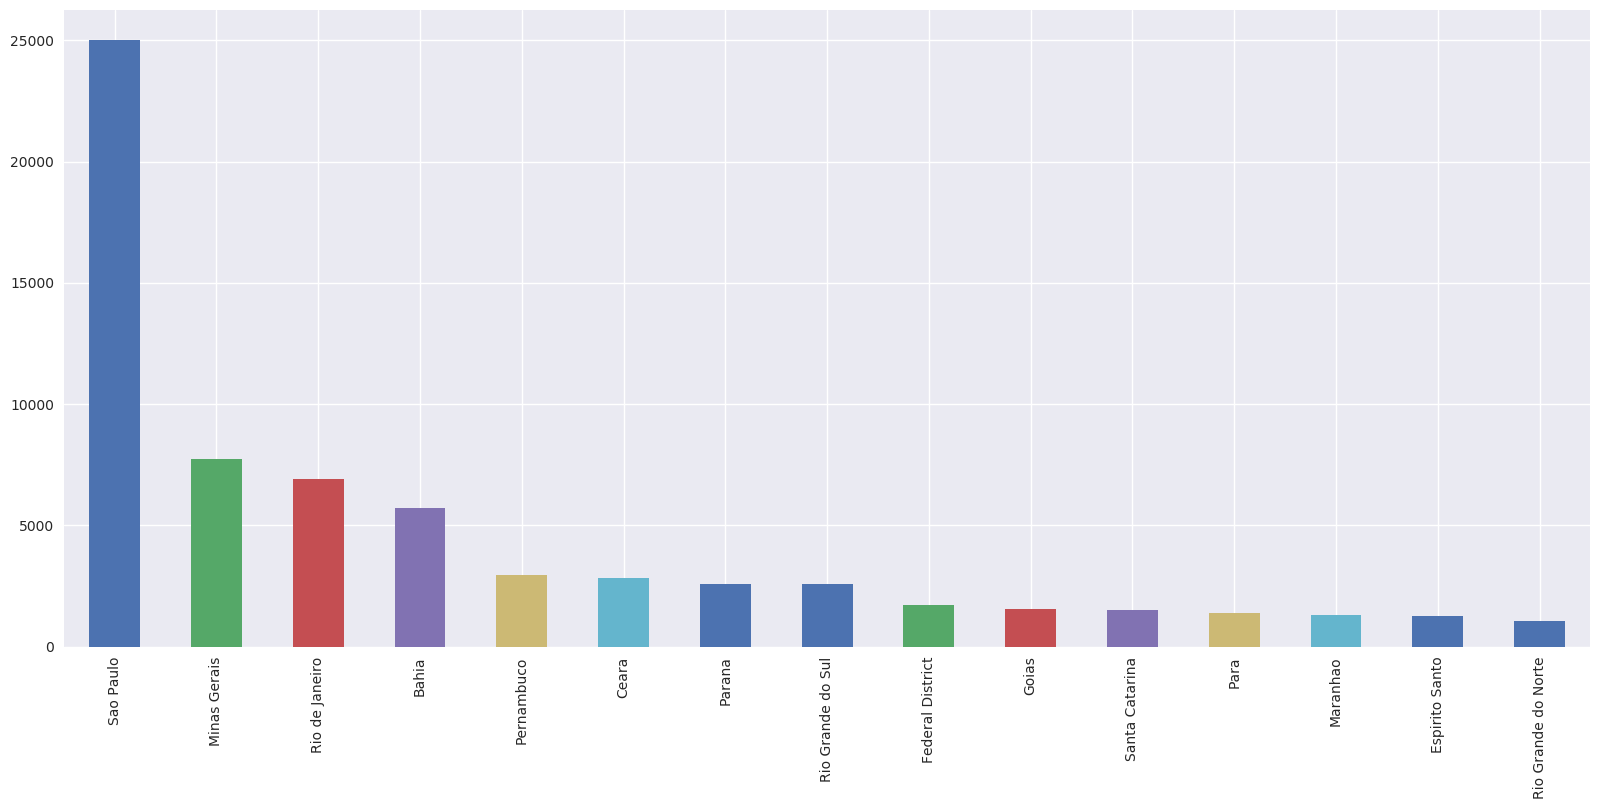

In [275]:
#Filtramos los 'Unknown'
visitas_brasil = visitas_brasil[visitas_brasil['region'] != 'Unknown']
visitas_brasil['region'].value_counts().head(15).plot('bar')

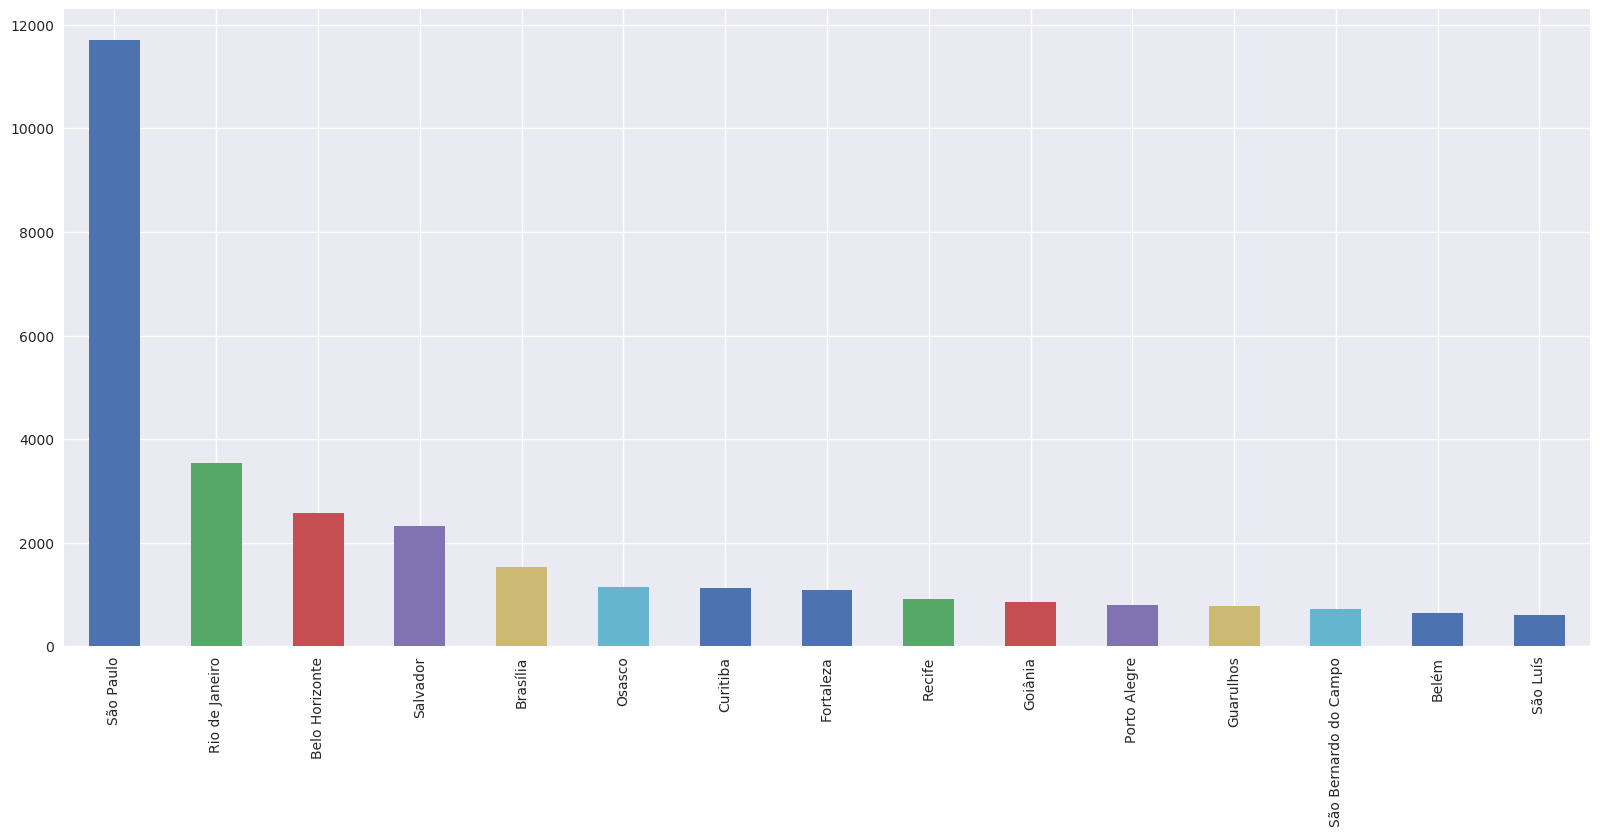

In [276]:
visitas_brasil = visitas_brasil[visitas_brasil['city'] != 'Unknown']
visitas_brasil['city'].value_counts().head(15).plot('bar')

### Falta meterle un Basemap!!!!!!!!!!!!!!!!!!!

## Captacion de usuarios

In [277]:
personas_new_ret = visitas.loc[:, ['person']]
personas_new_ret['returning_hits'] = visitas['new_vs_returning'] == 'Returning'
personas_new_ret.head()

,person,returning_hits
1,0004b0a2,False
5,0006a21a,False
9,000a54b2,False
16,000a54b2,True
45,00184bf9,False


In [278]:
personas_ret_hits = personas_new_ret.groupby(by = 'person').agg({'returning_hits': np.count_nonzero})
personas_ret_hits.head(10)

,returning_hits
person,
0004b0a2,0
0006a21a,0
000a54b2,1
00184bf9,1
0019c395,0
001bb7eb,1
001f1653,0
00204059,11
0024a82b,0


In [279]:
x = personas_ret_hits['returning_hits']
x.value_counts().head(10)

0    15768
1     3896
2     1987
3     1192
4      762
5      557
6      419
7      331
8      228
9      201
Name: returning_hits, dtype: int64

/home/facundo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Cantidad de usuarios según returning_hits')

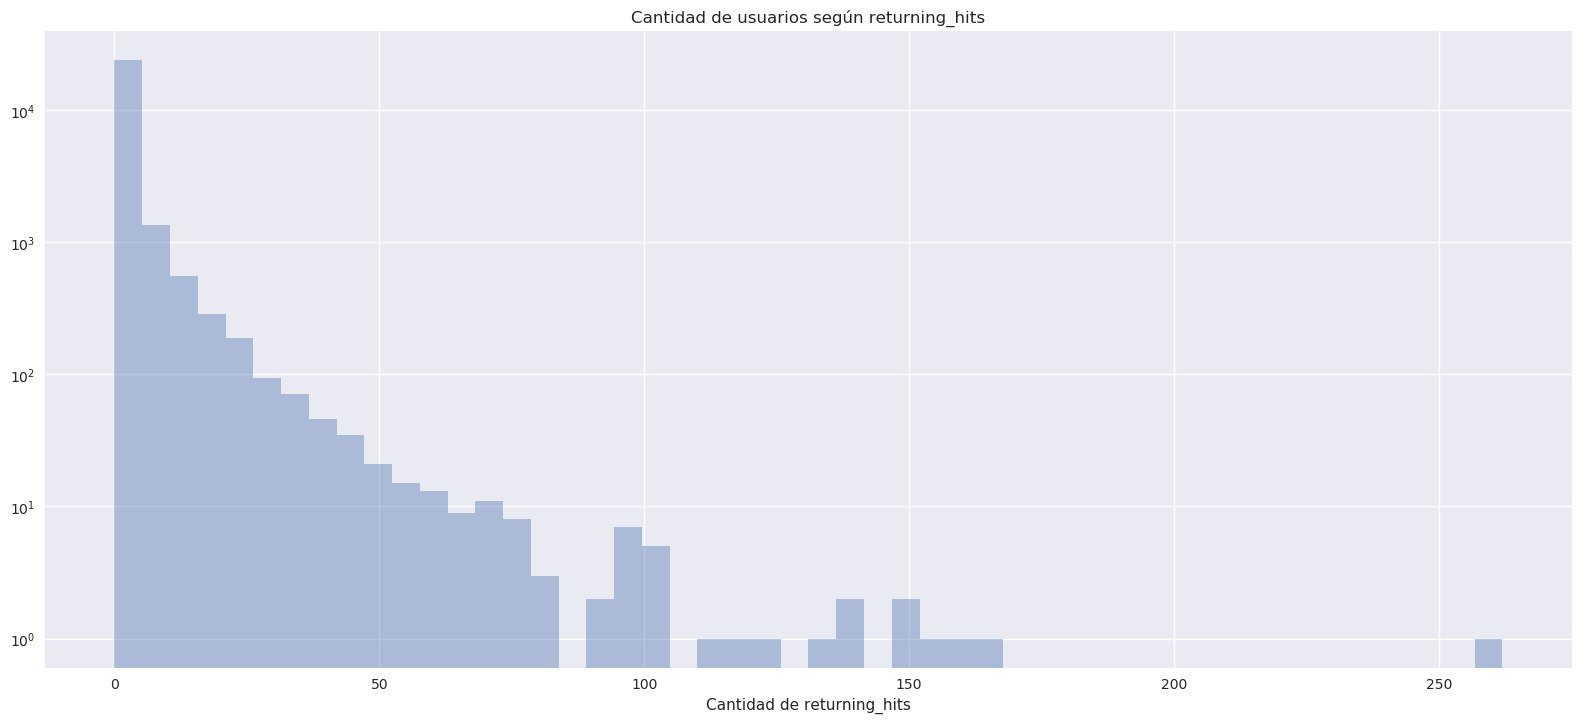

In [280]:
sns.distplot(x, hist_kws={'log':True}, kde = False, axlabel = 'Cantidad de returning_hits').set_title('Cantidad de usuarios según returning_hits')

La mayoría de los usuarios ingresa al sitio una única vez

[Text(0,0.5,'Cantidad de Usuarios'),
 Text(0.5,0,'Cantidad de visitas al sitio'),
 Text(0.5,1,'Cantidad de usuarios segun veces que visitaron el sitio')]

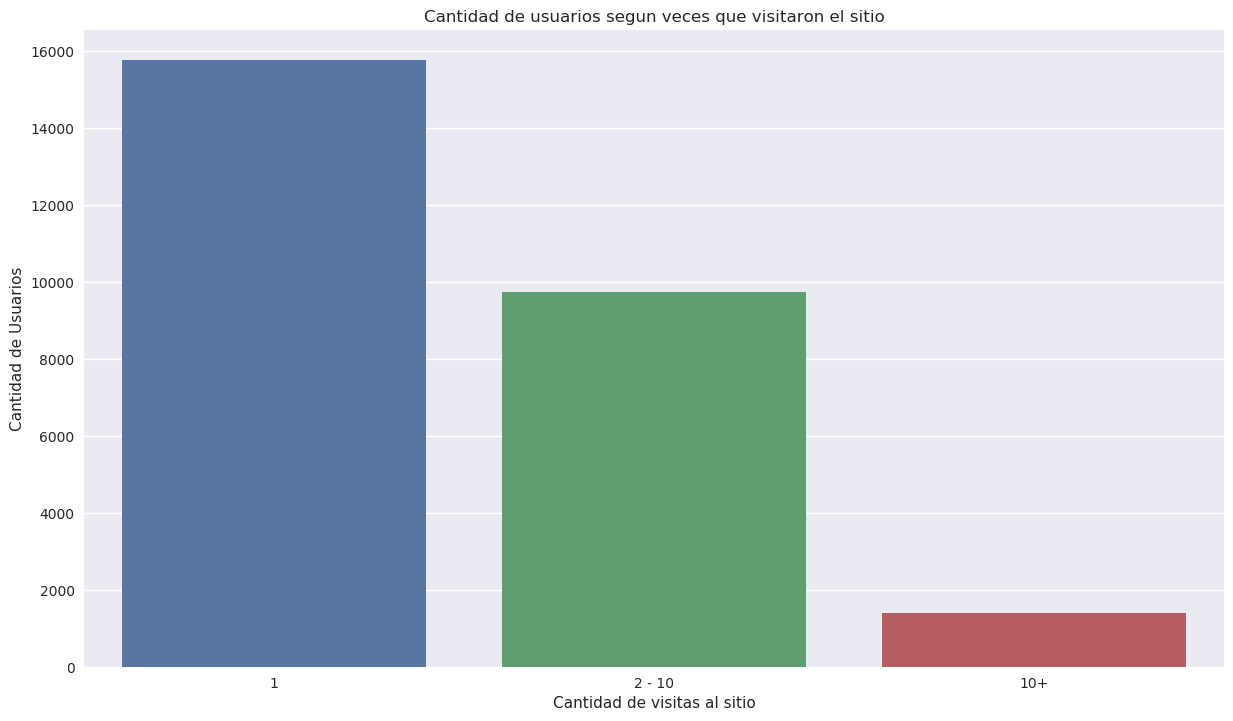

In [311]:
cant_returns = x.value_counts()
cero_returns = cant_returns[0]
uno_diez_returns = cant_returns[1:11].values.sum()
diez_mas_returns = cant_returns[11:].values.sum()
datos_returns = [cero_returns, uno_diez_returns, diez_mas_returns]
x_labels = ['1', '2 - 10', '10+']
ax = sns.barplot(x = x_labels, y = datos_returns)
ax.set(xlabel='Cantidad de visitas al sitio', ylabel='Cantidad de Usuarios', title = 'Cantidad de usuarios segun veces que visitaron el sitio')

La mayoria de los usuarios visita el sitio una única vez, mientras que solo una pequeña proporción volvió al sitio mas de 10 veces. Es posible que un mismo usuario entre desde dispositivos diferentes.

## Analisis temporal

Text(0.5,1,'Cantidad de eventos por dia de la semana')

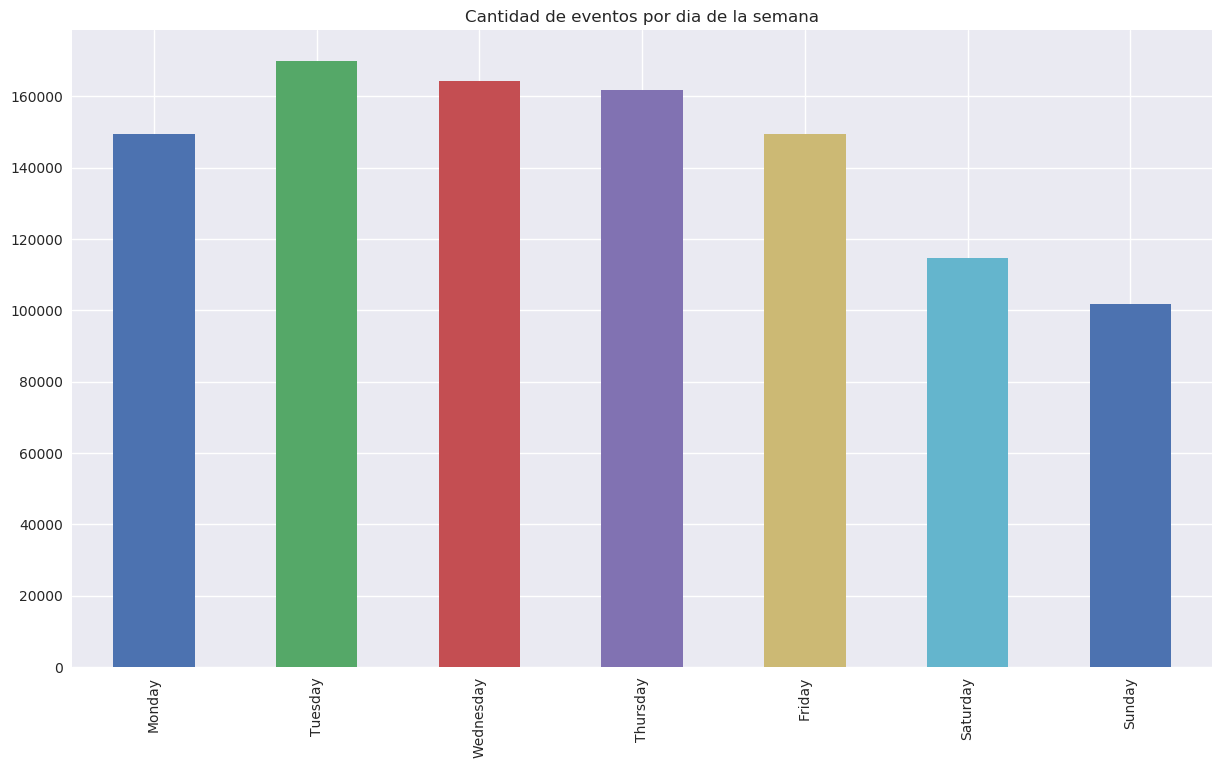

In [310]:
#Vamos a hacer un analisis sobre los dias en los que se produjeron los eventos
dias_semana = df['timestamp'].dt.weekday_name
dias_ordenados = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dias_semana = pd.Categorical(dias_semana, categories = dias_ordenados, ordered = True)
g = dias_semana.value_counts().plot('bar')
g.set_title('Cantidad de eventos por dia de la semana')

Vemos que durante el fin de semana el trafico es menor

In [283]:
tiempo_eventos = pd.DataFrame()
tiempo_eventos['event'] = df['event']
tiempo_eventos['dia_semana'] = df['timestamp'].dt.weekday_name
tiempo_eventos['hora'] = df['timestamp'].dt.hour
tiempo_eventos['mes'] = df['timestamp'].dt.month

tiempo_eventos = tiempo_eventos.groupby(by = ['dia_semana', 'event'])['hora'].value_counts()
tiempo_eventos = tiempo_eventos.rename(columns = {'hora':'cant_casos'})
tiempo_eventos = tiempo_eventos.reset_index(['event', 'hora'])
tiempo_eventos.index = pd.CategoricalIndex(tiempo_eventos.index, categories= reversed(dias_ordenados))
tiempo_eventos.sort_index(level=0, inplace=True)
tiempo_eventos = tiempo_eventos.reset_index()
tiempo_eventos = tiempo_eventos.rename(columns = {0:'cant_casos'})

[Text(154.472,0.5,'Dia de la semana'),
 Text(0.5,61.6922,'Hora'),
 Text(0.5,1,'Visitas segun hora del dia')]

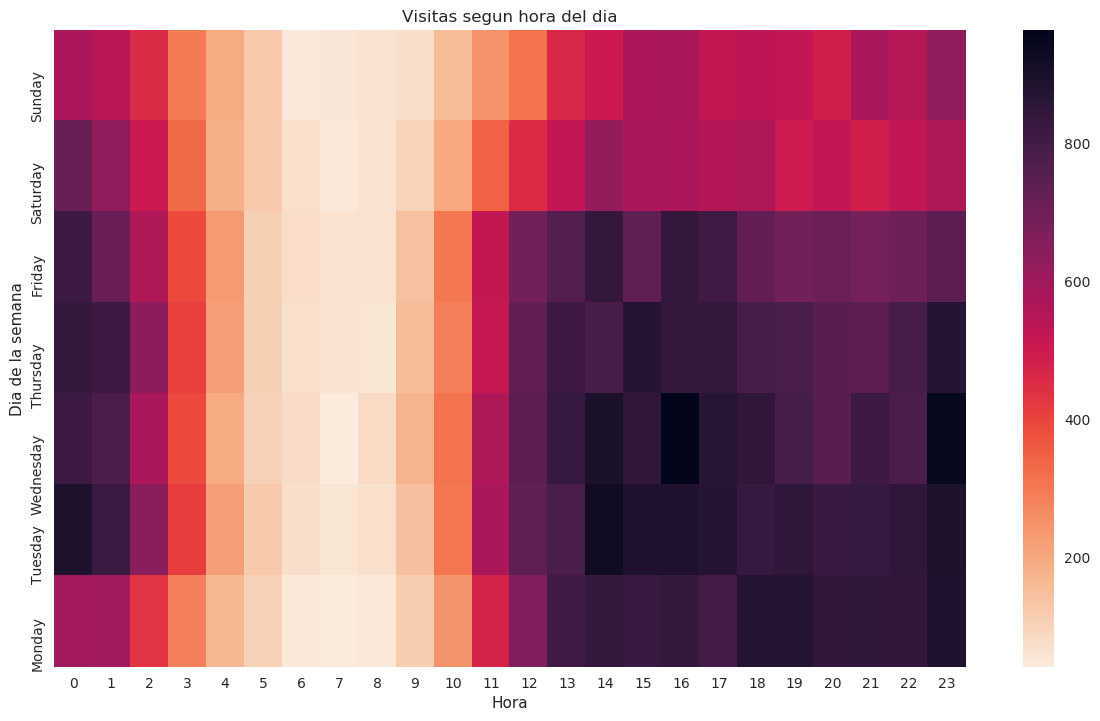

In [312]:
tiempo_visitas = tiempo_eventos[tiempo_eventos['event'] == 'visited site']
pivot = tiempo_visitas.pivot_table(index = 'dia_semana', columns = 'hora', values = 'cant_casos')
cmap = sns.cm.rocket_r
ax = sns.heatmap(data = pivot, cmap = cmap)
ax.set(xlabel='Hora', ylabel='Dia de la semana', title = 'Visitas segun hora del dia')

Durante el fin de semana la cantidad de visitas es menor, mientras que la mayoria de las visitas se realizan entre las 12 y las 2

## Origen de las visitas

In [285]:
visitas = df.loc[df["event"] == "visited site", ['timestamp', 'person', 'channel', 'new_vs_returning', 'city', 'region', 'country', 'device_type', 'screen_resolution', 'operating_system_version', 'browser_version']]
colors = {'Paid': 'navy', 'Direct': 'g', 'Organic': 'coral', 'Referral': 'm', 'Social': 'goldenrod', 'Email': 'k', 'Unknown': 'grey'}

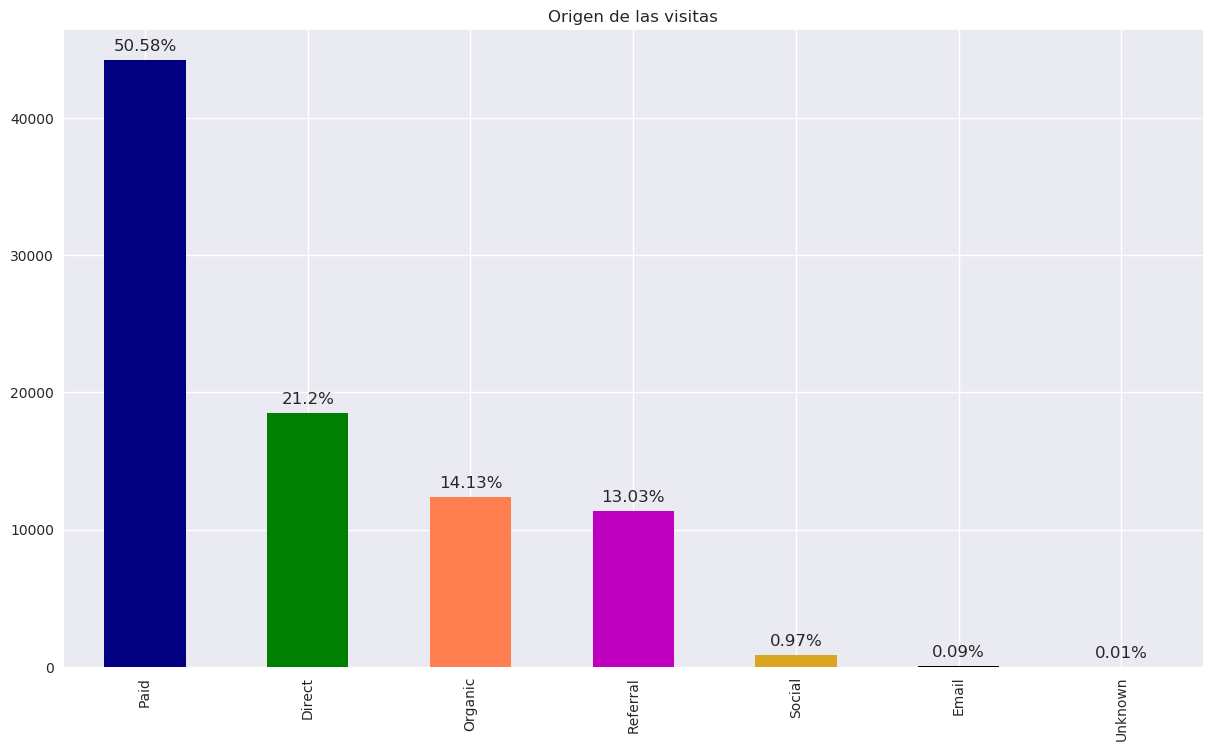

In [313]:
valores = visitas['channel'].value_counts()
ax = valores.plot(kind = 'bar', color=[colors.get(i) for i in valores.index])
ax.set_title('Origen de las visitas')
mostrar_porcentaje_barplot(ax)

### Origen de usuarios nuevos

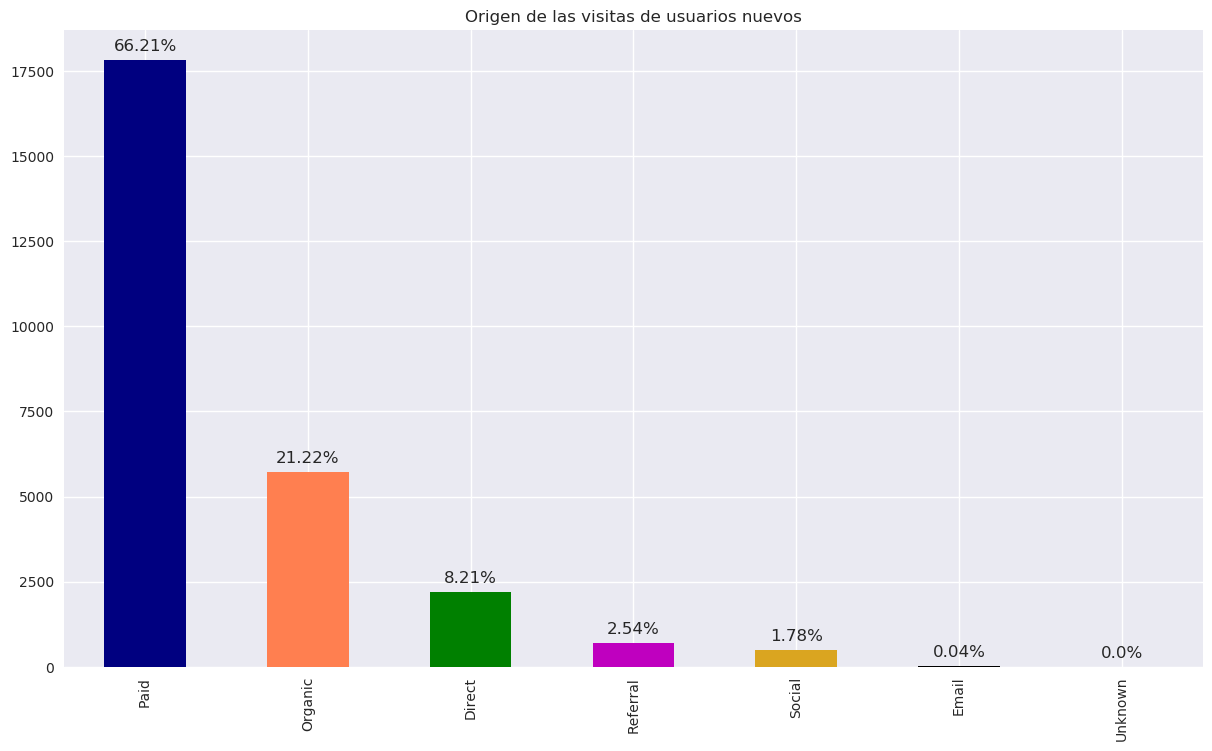

In [314]:
valores = visitas[visitas['new_vs_returning'] == 'New']['channel'].value_counts()
ax = valores.plot(kind = 'bar', color=[colors.get(i) for i in valores.index])
ax.set_title('Origen de las visitas de usuarios nuevos')
mostrar_porcentaje_barplot(ax)

### Origen usuarios no nuevos

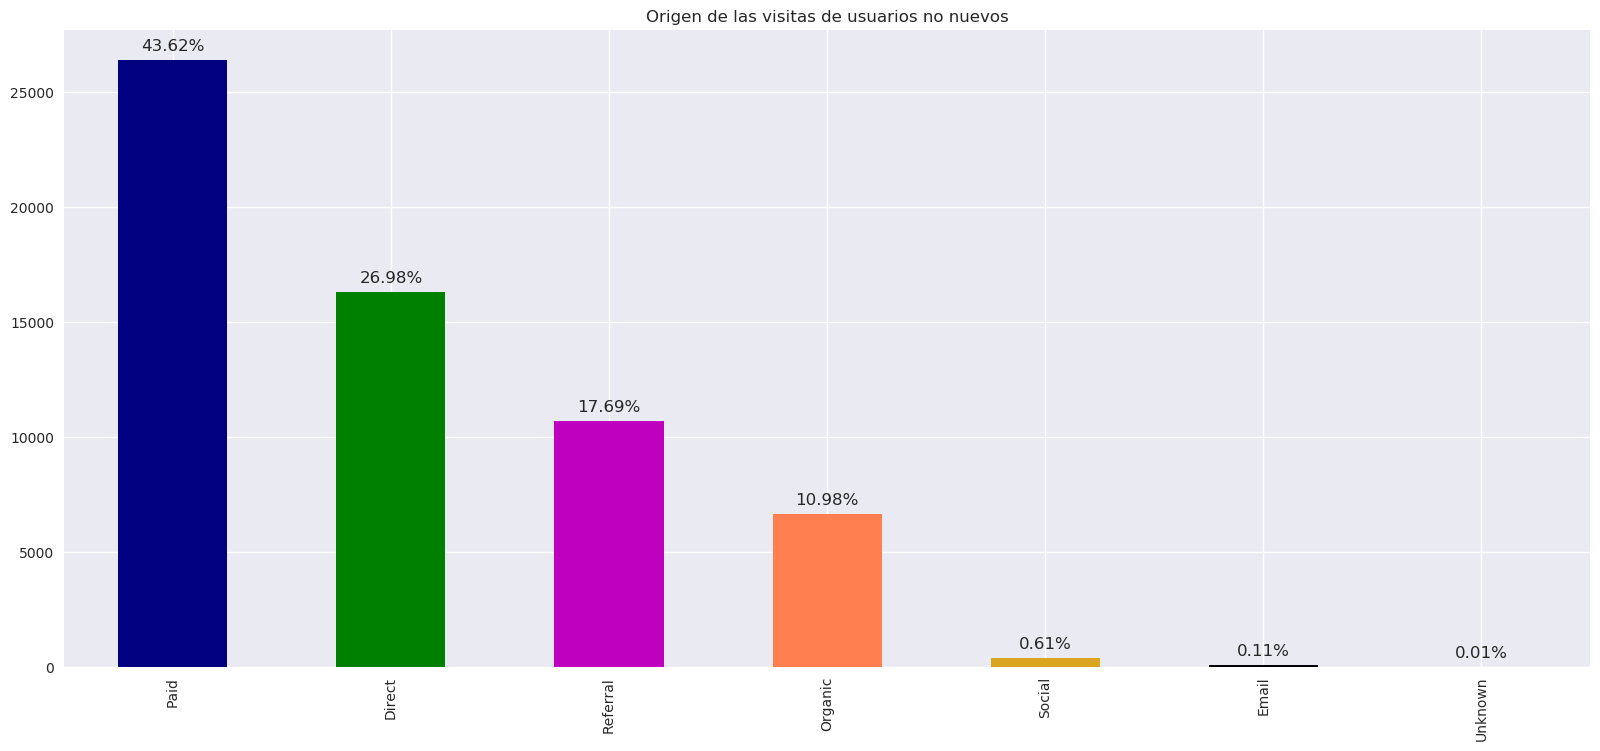

In [288]:
valores = visitas[visitas['new_vs_returning'] == 'Returning']['channel'].value_counts()
ax = valores.plot(kind = 'bar', color=[colors.get(i) for i in valores.index])
ax.set_title('Origen de las visitas de usuarios no nuevos')
mostrar_porcentaje_barplot(ax)

<font size=3>Vemos que el canal pago es el que mas visitas atrae, no solo para usuarios nuevos sino tambien para usuarios que ya habian entrado al sitio. Por otro lado, se puede ver como el canal "Direct" (tipeado de URL, acceso mediante favoritos y similares) toma protagonismo para visitas de usuarios que ya conocen el sitio. Pero esto puede ser causado por un pequenio numero de usuarios que visitan repetidas veces el sitio</font>

<font size=3>Por lo tanto ahora tomaremos solo un metodo predominante de acceso al sitio por usuario, para usarios no nuevos</font>

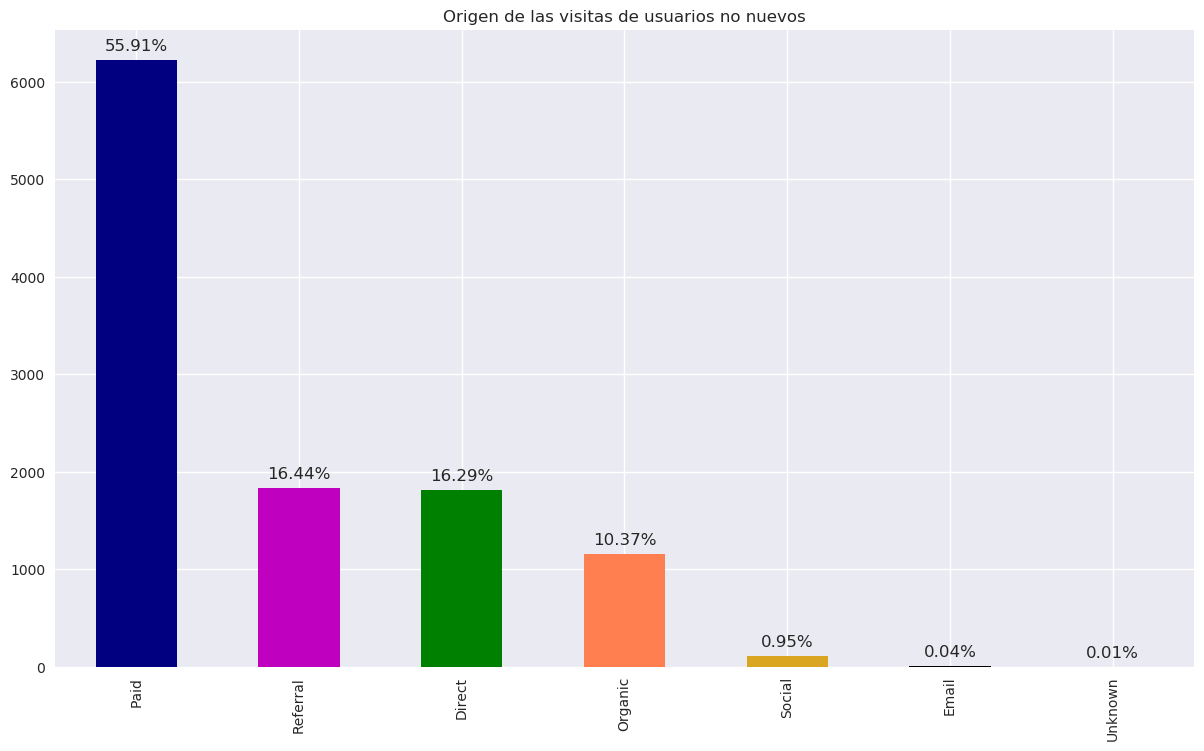

In [315]:
valores = visitas[visitas['new_vs_returning'] == 'Returning'].groupby('person')['channel'].agg(lambda x: x.value_counts().index[0]).value_counts()

ax = valores.plot(kind = 'bar', color=[colors.get(i) for i in valores.index])
ax.set_title('Origen de las visitas de usuarios no nuevos')
mostrar_porcentaje_barplot(ax)

In [290]:
df_indice_en_persona_evento = df.set_index(['person','event'])
df_indice_en_persona_evento.head(50)

timestamp                         url  \
person   event                                                               
0004b0a2 ad campaign hit   2018-05-31 23:38:05   /comprar/iphone/iphone-5s   
         visited site      2018-05-31 23:38:05                         NaN   
         viewed product    2018-05-31 23:38:09                         NaN   
         checkout          2018-05-31 23:38:40                         NaN   
0006a21a viewed product    2018-05-29 13:29:25                         NaN   
         visited site      2018-05-29 13:29:26                         NaN   
         ad campaign hit   2018-05-29 13:29:27  /comprar/samsung/galaxy-s8   
         checkout          2018-05-29 13:29:35                         NaN   
000a54b2 generic listing   2018-04-09 20:12:31                         NaN   
         visited site      2018-04-09 20:12:31                         NaN   
         search engine hit 2018-04-09 20:12:31                         NaN   
         ad campaign hit   2018-04-09 20:12:31                           /   
         brand listing     2018-04-09 20:12:53                         NaN   
         viewed product    2018-04-09 20:13:14                         NaN   
         brand listing     2018-04-09 20:13:20                         NaN   
         ad campaign hit   2018-05-24 11:21:07                           /   
         visited site      2018-05-24 11:21:07                         NaN   
         search engine hit 2018-05-24 11:21:07                         NaN   
         generic listing   2018-05-24 11:21:08                         NaN   
         generic listing   2018-05-24 11:26:34                         NaN   
         brand listing     2018-05-24 11:26:53                         NaN   
         generic listing   2018-05-24 11:26:56                         NaN   
         viewed product    2018-05-24 11:27:47                         NaN   
         generic listing   2018-05-24 11:27:50                         NaN   
         brand listing     2018-05-24 11:28:10                         NaN   
         brand listing     2018-05-24 11:28:36                         NaN   
         viewed product    2018-05-24 11:28:59                         NaN   
         viewed product    2018-05-24 11:29:06                         NaN   
         viewed product    2018-05-24 11:29:14                         NaN   
         viewed product    2018-05-24 11:29:16                         NaN   
         viewed product    2018-05-24 11:29:19                         NaN   
         viewed product    2018-05-24 11:29:23                         NaN   
         viewed product    2018-05-24 11:30:07                         NaN   
         viewed product    2018-05-24 11:30:09                         NaN   
         viewed product    2018-05-24 11:30:11                         NaN   
         viewed product    2018-05-24 11:30:15                         NaN   
         viewed product    2018-05-24 11:30:16                         NaN   
         viewed product    2018-05-24 11:30:18                         NaN   
         viewed product    2018-05-24 11:30:22                         NaN   
         viewed product    2018-05-24 11:30:24                         NaN   
         viewed product    2018-05-24 11:30:26                         NaN   
         viewed product    2018-05-24 11:30:29                         NaN   
         brand listing     2018-05-24 11:32:39                         NaN   
         viewed product    2018-05-24 11:33:23                         NaN   
         checkout          2018-05-24 11:34:32                         NaN   
00184bf9 visited site      2018-04-06 05:12:05                         NaN   
         brand listing     2018-04-06 05:12:05                         NaN   
         search engine hit 2018-04-06 05:12:05                         NaN   
         viewed product    2018-04-06 05:12:26                         NaN   
         viewed product    2018-04-06 05:12:27             

In [291]:
def ver_diferencia_tiempo(tiempo):
    return tiempo.max()-tiempo.min()
    
diferencia_tiempo_entre_primero_y_ultimo_evento = df_indice_en_persona_evento.groupby('person').agg({'timestamp':ver_diferencia_tiempo})

In [292]:
diferencia_tiempo_entre_primero_y_ultimo_evento.loc[diferencia_tiempo_entre_primero_y_ultimo_evento['timestamp']>'1 day'].sort_values(by = 'timestamp')

,timestamp
person,
090de13e,1 days 00:02:28
c56e464b,1 days 00:02:34
482292d0,1 days 00:02:43
274c909c,1 days 00:03:07
20804569,1 days 00:03:11
883d144b,1 days 00:03:18
a7bc3bc9,1 days 00:03:21
cbd6d5ce,1 days 00:04:25
1e32b30a,1 days 00:05:04


# Quiero ver Que campaña publicitaria lleva a mas ventas

In [293]:
personas_por_publicidad = {}
    
ad_campaigns = df.loc[(df['event']=='ad campaign hit') | (df['event']=='conversion')].drop_duplicates()#[['person','campaign_source']].drop_duplicates().set_index('campaign_source')
ad_campaigns

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-05-29 13:29:27,ad campaign hit,0006a21a,/comprar/samsung/galaxy-s8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2018-04-09 20:12:31,ad campaign hit,000a54b2,/,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,2018-05-24 11:21:07,ad campaign hit,000a54b2,/,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,2018-05-17 00:08:56,ad campaign hit,0019c395,/comprar/samsung/galaxy-j5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,2018-05-17 00:11:10,ad campaign hit,0019c395,/comprar/samsung/galaxy-j5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,2018-06-08 12:15:33,ad campaign hit,001bb7eb,/comprar/iphone/6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111,2018-05-29 12:56:08,ad campaign hit,001f1653,/comprar/samsung/galaxy-s6-flat,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,2018-01-31 16:54:29,ad campaign hit,00204059,/,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,2018-02-01 23:32:02,ad campaign hit,00204059,/comprar/iphone,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [294]:
ad_campaigns_cool = df.loc[(df['event']=='ad campaign hit'),['person','campaign_source']].drop_duplicates()
ad_campaigns_cool.head()

,person,campaign_source
0,0004b0a2,criteo
6,0006a21a,criteo
11,000a54b2,google
99,0019c395,google
107,001bb7eb,google


In [295]:
personas_que_compraron = df.loc[df['event']=='conversion',['person']].drop_duplicates()
personas_que_compraron['compro'] = True
personas_que_compraron.head()

,person,compro
220,00204059,True
2282,00c13dee,True
2547,00fdbb4b,True
4245,0146a9df,True
6985,01db2fe6,True


In [296]:
compras_por_campania = pd.merge(ad_campaigns_cool, personas_que_compraron, on='person', how='left')
compras_por_campania.head(10)

,person,campaign_source,compro
0,0004b0a2,criteo,NaN
1,0006a21a,criteo,NaN
2,000a54b2,google,NaN
3,0019c395,google,NaN
4,001bb7eb,google,NaN
5,001f1653,criteo,NaN
6,00204059,FacebookAds,True
7,00204059,zanox,True
8,00204059,google,True
9,0024a82b,google,NaN


In [297]:
compras2 = compras_por_campania.groupby('campaign_source').agg({'person': 'count','compro':'count'})
compras2.head()

,person,compro
campaign_source,,
Facebook,44,5
FacebookAds,407,28
FacebookSocial,6,1
Google Social,1,0
MARKETING SOCIAL,1,0


Text(0,0.5,'Cantidad de hits')

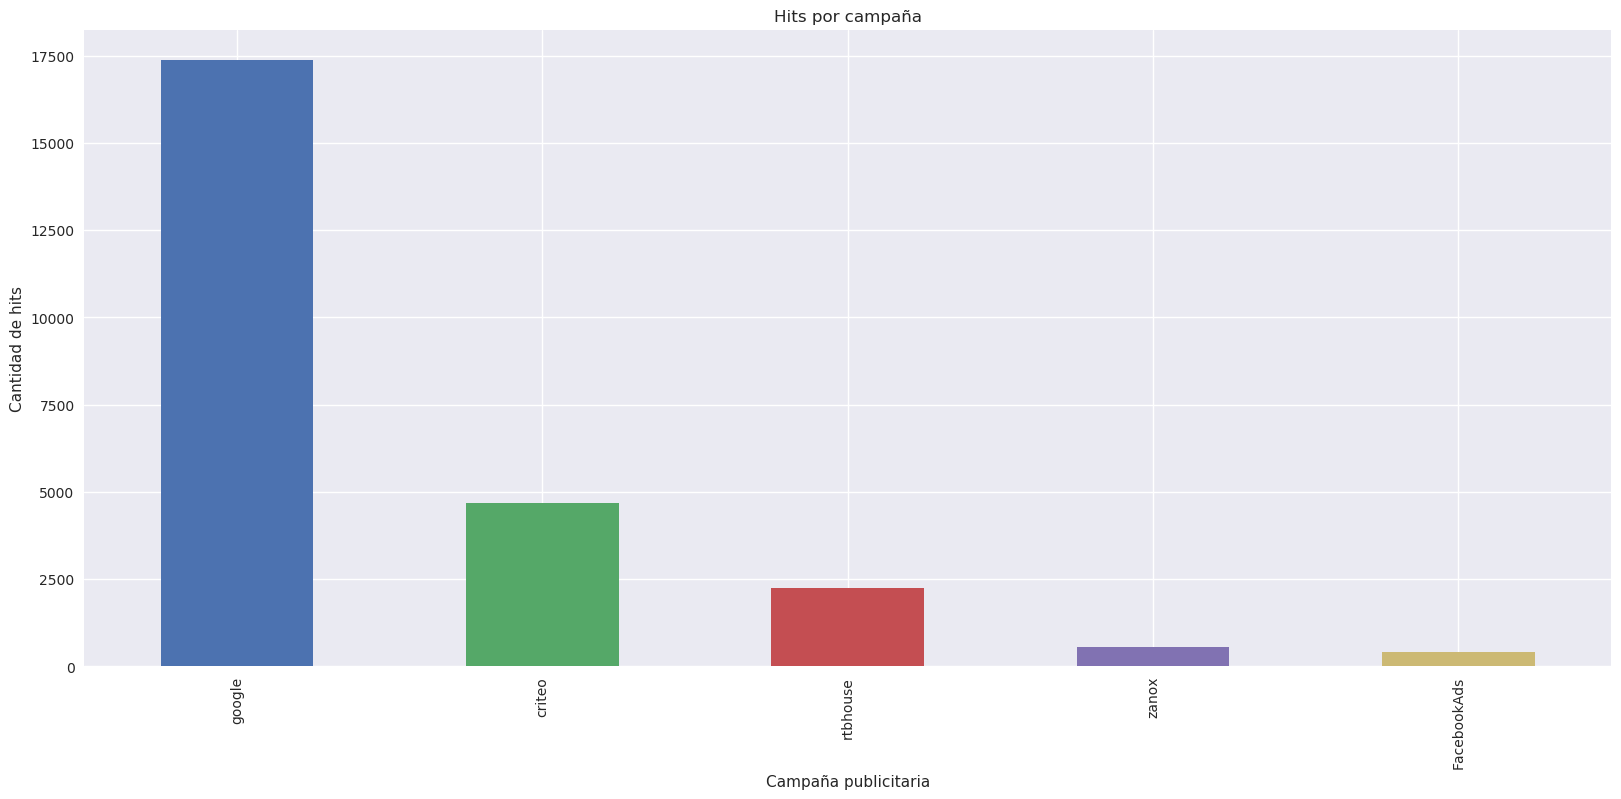

In [298]:
g = compras2['person'].sort_values(ascending=False).head().plot('bar')
g.set_title('Hits por campaña')
g.set_xlabel('Campaña publicitaria')
g.set_ylabel('Cantidad de hits')

Text(0.5,1,'Cantidad de compras realizadas por campaña')

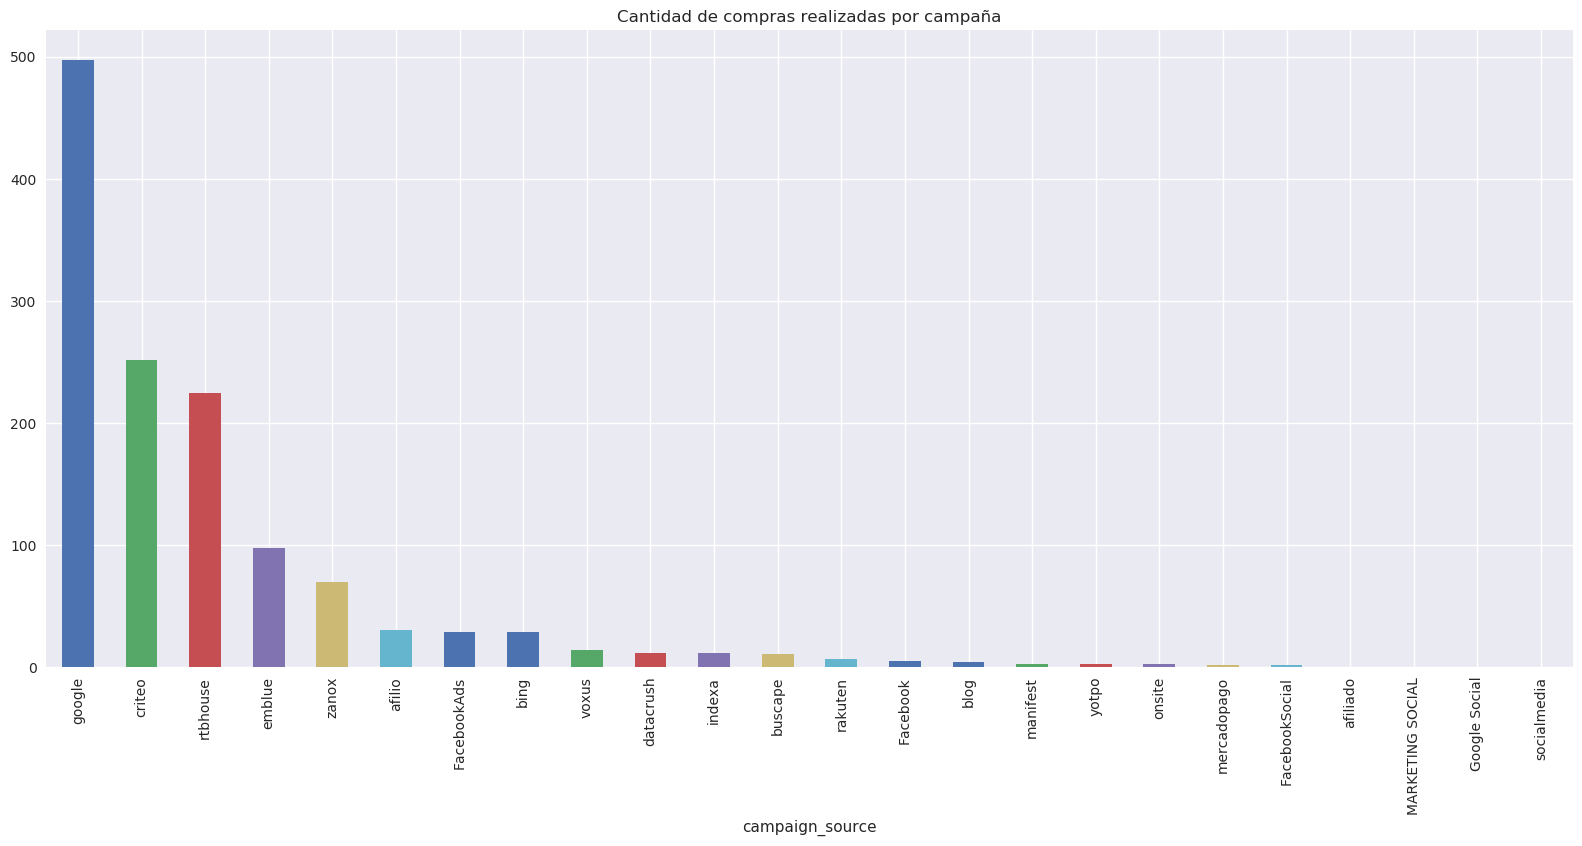

In [299]:
g2 = compras2['compro'].sort_values(ascending=False).plot('bar')
g2.set_title('Cantidad de compras realizadas por campaña')

Text(0.5,1,'Porcentaje de compras logradas por campaña publicitaria')

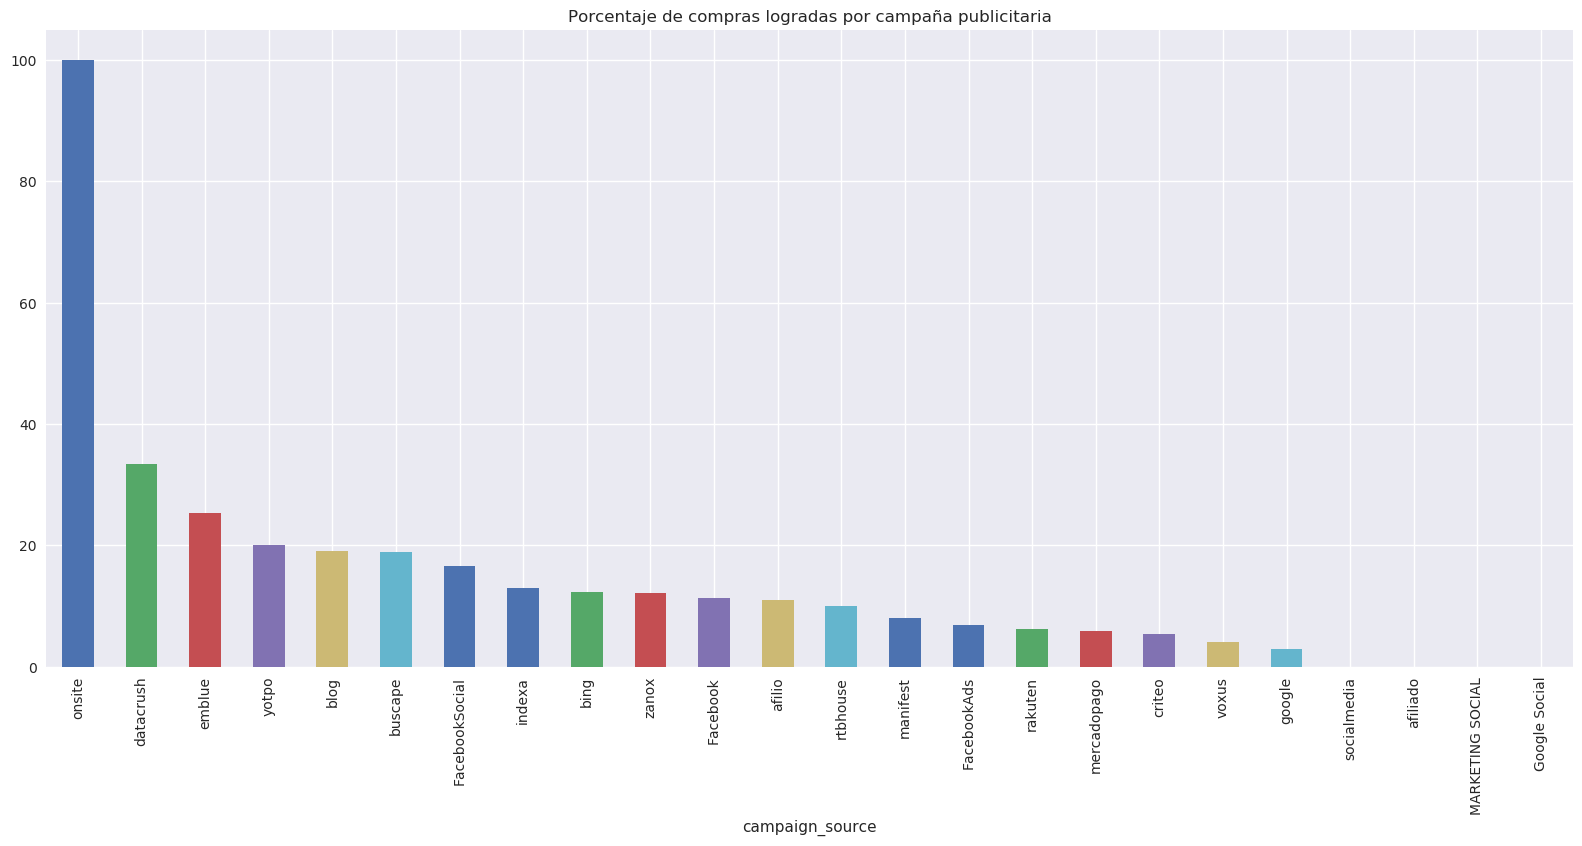

In [300]:
compras2['porcentaje'] = 100* (compras2['compro']/compras2['person'])
g3 = compras2['porcentaje'].sort_values(ascending=False).plot('bar')
g3.set_title('Porcentaje de compras logradas por campaña publicitaria')

Hay una "campaña publicitaria" llamada onsite que debería ser eliminada del data frame

## Analisis por dispositivo 

In [301]:
df['device_type'].value_counts()

Smartphone    44239
Computer      41790
Tablet         1234
Unknown         115
Name: device_type, dtype: int64

Text(0,0.5,'Cantidad de personas')

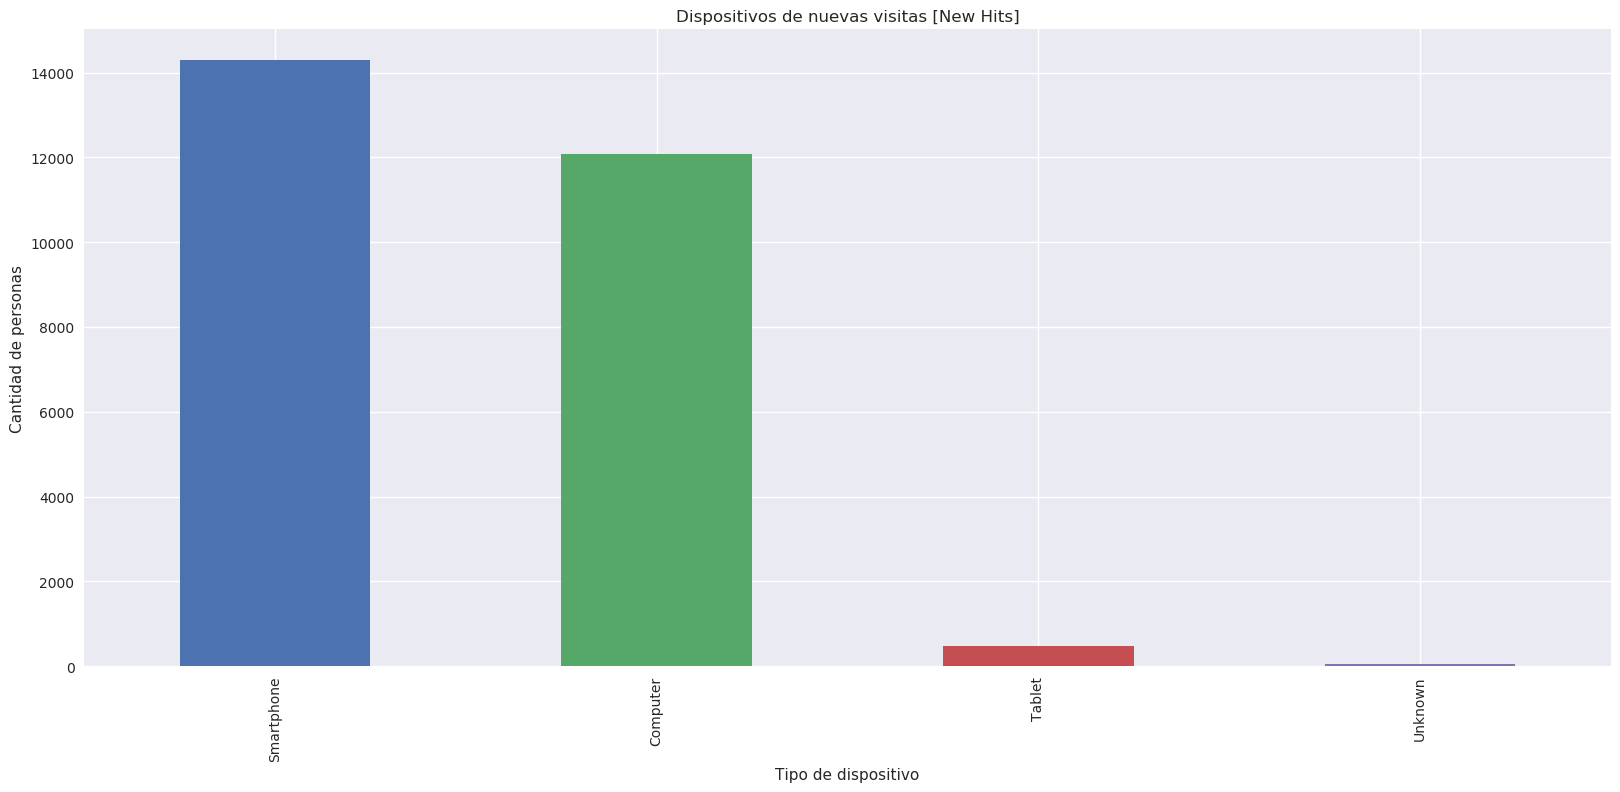

In [302]:
dispositivos_registrados = df.loc[(df['event']=='visited site'),['person','device_type','new_vs_returning']]
dispositivos_nuevos = dispositivos_registrados.loc[dispositivos_registrados['new_vs_returning']=='New']

g_dispositivos_nuevos = dispositivos_nuevos['device_type'].value_counts().plot('bar')
g_dispositivos_nuevos.set_title('Dispositivos de nuevas visitas [New Hits]')
g_dispositivos_nuevos.set_xlabel('Tipo de dispositivo')
g_dispositivos_nuevos.set_ylabel('Cantidad de personas')

Los unicos dispositivos relevantes son los de Smartphones y Computadoras

In [303]:
#Filtro las personas entraron por primera vez por su celular
personas_nuevas_smartphone = dispositivos_nuevos.loc[(dispositivos_nuevos['device_type']=='Smartphone'),['person']]

#Filtro paralelamente las personas que volvieron a entrar desde sus PCs
personas_returning_pc = dispositivos_registrados.loc[(dispositivos_registrados['device_type']=='Computer') & (df['new_vs_returning']=='Returning'),['person']]
personas_returning_pc['Volvieron_en_PC'] = True

In [304]:
personas_new_Smartphone_ret_PC = pd.merge(personas_nuevas_smartphone, personas_returning_pc, on='person', how='left').drop_duplicates()
personas_new_Smartphone_ret_PC['Volvieron_en_PC'].fillna(False,inplace=True)
personas_new_Smartphone_ret_PC.describe()

,person,Volvieron_en_PC
count,14305,14305
unique,14305,2
top,00adbcd1,False
freq,1,13971


#### Veo la cantidad de personas que entraron por primera vez a la página desde sus celulares y volvieron desde sus PCs

In [305]:
cantidad_personas_que_volvieron_enPC = personas_new_Smartphone_ret_PC['Volvieron_en_PC'].value_counts()
cantidad_personas_que_volvieron_enPC


False    13971
True       334
Name: Volvieron_en_PC, dtype: int64

Text(0,0.5,'Cantidad de personas')

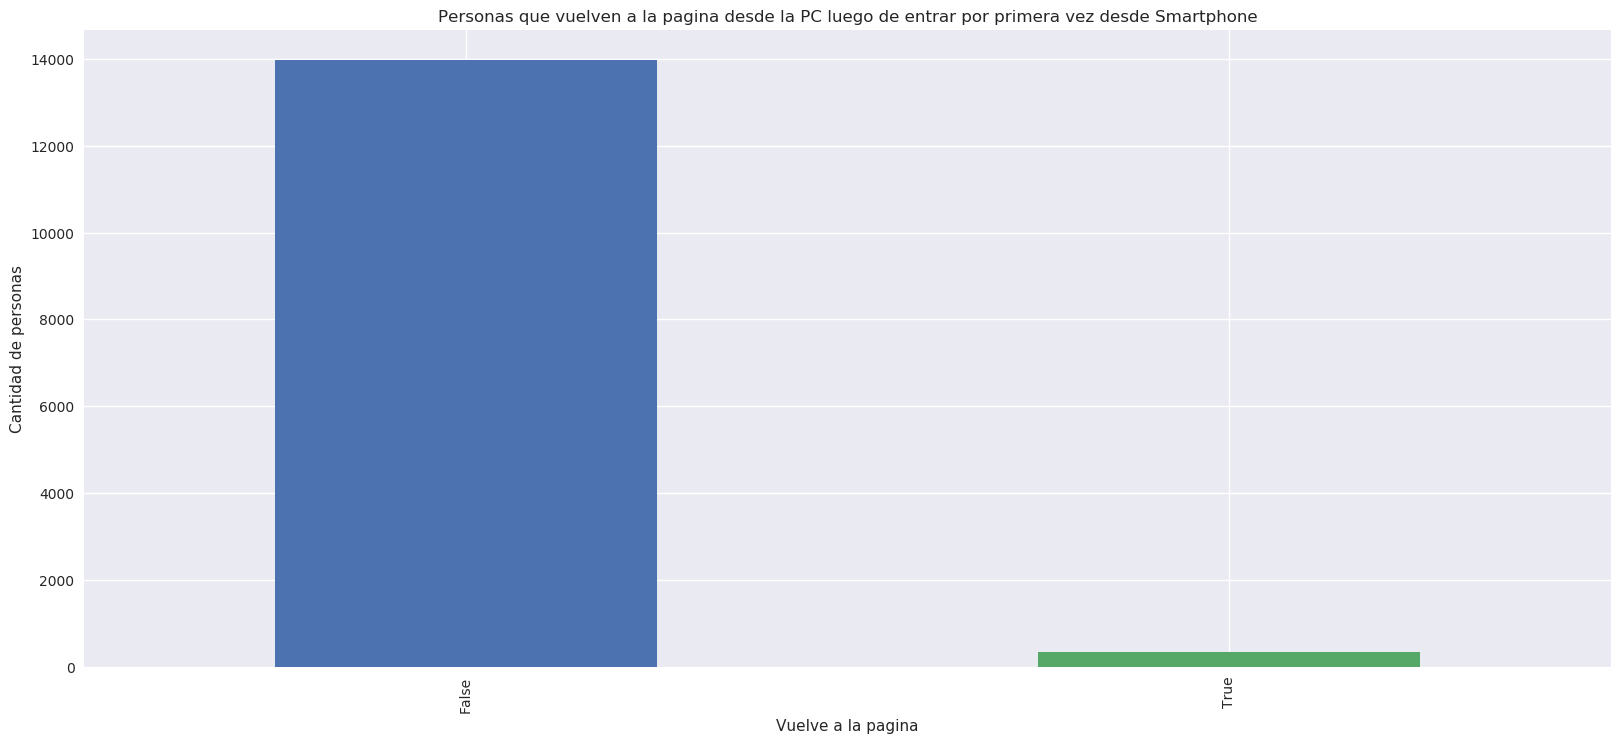

In [306]:
g_personas_ret_PC = cantidad_personas_que_volvieron_enPC.plot('bar')
g_personas_ret_PC.set_title('Personas que vuelven a la pagina desde la PC luego de entrar por primera vez desde Smartphone')
g_personas_ret_PC.set_xlabel('Vuelve a la pagina')
g_personas_ret_PC.set_ylabel('Cantidad de personas')

Se nota que no es representativa el numero de personas que entran primero a la pagina por sus celulares y luego vuelven a entrar desde la PC

#### Analizamos si de las personas que vuelven a entrar desde la PC (y que primero ingresaron con sus Smartphones) terminan realizando alguna compra

In [307]:
personas_vuelven_y_compran = pd.merge(personas_new_Smartphone_ret_PC, personas_que_compraron, on='person', how='left').drop_duplicates()
personas_vuelven_y_compran['compro'].fillna(False,inplace=True)
personas_vuelven_y_compran.loc[personas_vuelven_y_compran['Volvieron_en_PC']==True]['compro'].value_counts(normalize = True)

False    0.715569
True     0.284431
Name: compro, dtype: float64

Text(0,0.5,'Cantidad de personas')

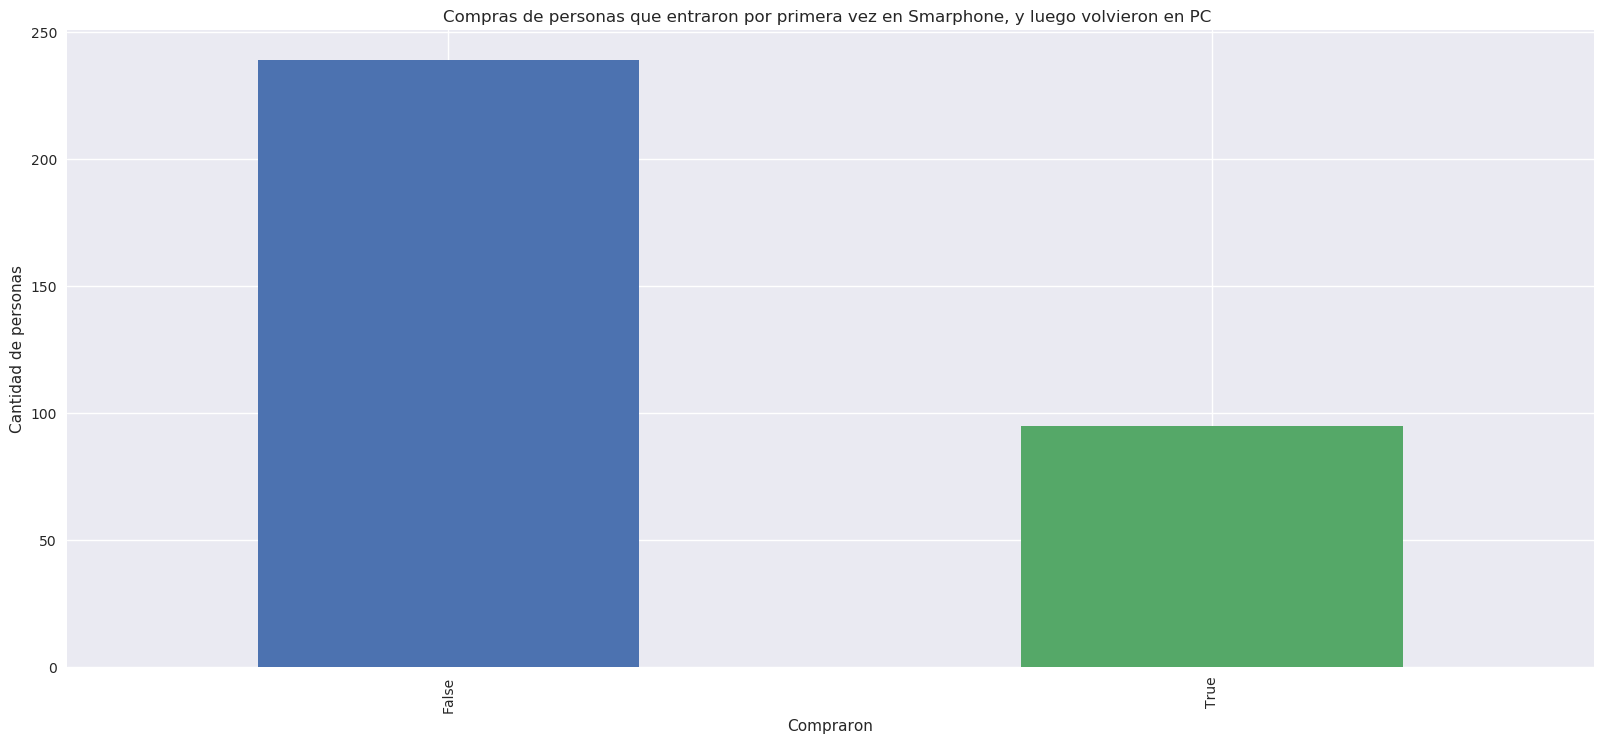

In [308]:
g5 = personas_vuelven_y_compran.loc[personas_vuelven_y_compran['Volvieron_en_PC']==True]['compro'].value_counts().plot('bar',)
g5.set_title("Compras de personas que entraron por primera vez en Smarphone, y luego volvieron en PC ")
g5.set_xlabel("Compraron")
g5.set_ylabel("Cantidad de personas")

Podemos ver que de las personas que volvieron a la pagina desde sus PCs luego de entrar desde sus SmartPhones, un 28,4% realizo compras

## IDEAS
Se puede analizar desde el primer evento (el visited_site con New) de cada usuario, tomando este evento como el cero; cuanto tiempo le lleva o tarda en realizar mas acciones en la pagina